# dividends vs no-dividends

Compare SPY with and without dividends.

In [1]:
import datetime

import matplotlib.pyplot as plt
import pandas as pd

import pinkfish as pf

# Format price data.
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [2]:
# Set size of inline plots.
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

Some global data

In [3]:
symbol = 'SPY'
capital = 10000
start = datetime.datetime(1900, 1, 1)                   
end = datetime.datetime.now()

Timeseries

In [4]:
# Fetch timeseries, select, finalize.
ts = pf.fetch_timeseries(symbol)
ts = pf.select_tradeperiod(ts, start, end, use_adj=True)
ts, start = pf.finalize_timeseries(ts, start)

# Create tradelog and daily balance objects.
tlog = pf.TradeLog(symbol)
dbal = pf.DailyBal()

In [5]:
ts

,open,high,low,close,adj_close,volume
date,,,,,,
1993-01-29,24.54,24.54,24.42,24.53,24.53,1003200
1993-02-01,24.54,24.70,24.54,24.70,24.70,480500
1993-02-02,24.68,24.77,24.63,24.75,24.75,201300
1993-02-03,24.79,25.03,24.77,25.01,25.01,529400
1993-02-04,25.10,25.17,24.82,25.12,25.12,531500
...,...,...,...,...,...,...
2024-12-20,581.77,595.75,580.91,591.15,591.15,125716700
2024-12-23,590.89,595.30,587.66,594.69,594.69,57635800
2024-12-24,596.06,601.34,595.47,601.30,601.30,33160100


Algorithm

In [6]:
pf.TradeLog.cash = capital

# Loop through timeseries.
for i, row in enumerate(ts.itertuples()):

    date = row.Index.to_pydatetime()
    end_flag = pf.is_last_row(ts, i)

    # Buy.
    if tlog.shares == 0:
        tlog.buy(date, row.close)
    # Sell.
    elif end_flag:
        tlog.sell(date, row.close)

    # Record daily balance.
    dbal.append(date, row.close)

Retrieve logs and get stats

In [7]:
tlog = tlog.get_log()
dbal = dbal.get_log(tlog)
stats = pf.stats(ts, tlog, dbal, capital)

Benchmark: Run, retrieve logs, generate stats

In [8]:
benchmark = pf.Benchmark(symbol, capital, start, end, use_adj=False)
benchmark.run()

Plot Equity Curves: Dividends (strategy) vs No-Dividends (benchmark)

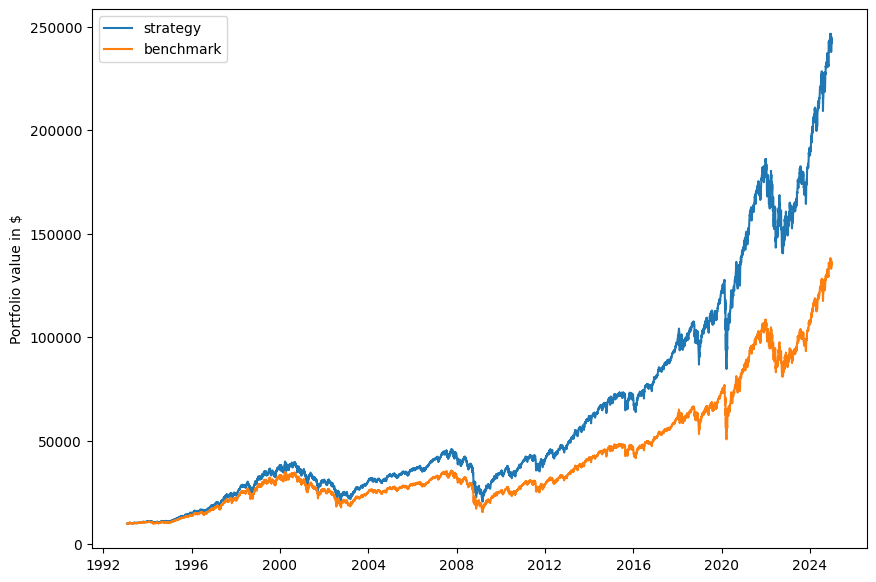

In [9]:
pf.plot_equity_curve(dbal, benchmark=benchmark.dbal, fname='equity_curve.png')

Dividends (strategy) vs No-Dividends (benchmark)

In [10]:
pf.summary(stats, benchmark.stats, metrics=pf.currency_metrics)

,strategy,benchmark
beginning_balance,"$10,000.00","$10,000.00"
ending_balance,"$242,186.97","$135,093.46"
total_net_profit,"$232,186.97","$125,093.46"
gross_profit,"$232,186.97","$125,093.46"
gross_loss,$0.00,$0.00


,strategy,benchmark
annual_return_rate,10.50,8.50
max_closed_out_drawdown,-55.17,-56.43
annualized_return_over_max_drawdown,0.19,0.15
best_month,23.60,23.06
worst_month,-30.98,-31.38
sharpe_ratio,0.63,0.53
sortino_ratio,0.80,0.68
monthly_std,4.44,4.44
annual_std,17.03,16.72
avg_month,0.90,0.75


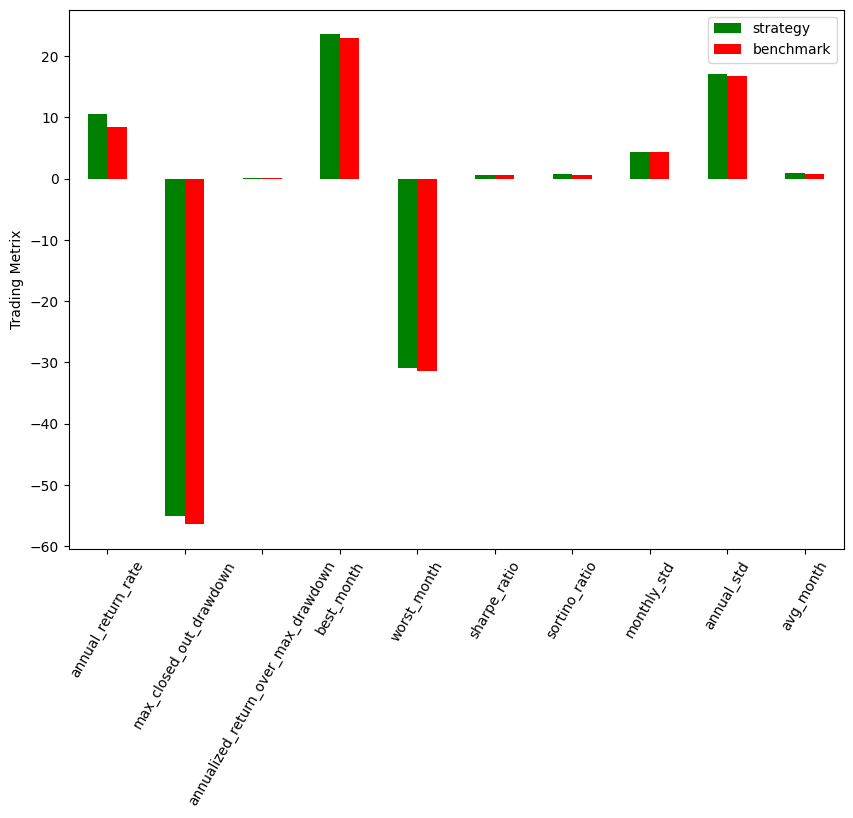

In [11]:
pf.plot_bar_graph(stats, benchmark.stats, extras=('avg_month',))